### Импорт библиотек

In [528]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

### Загрузка файлов

In [529]:
# Загрузка моделей
with open('models/catboost_model.pkl', 'rb') as f:
    model_catboost = pickle.load(f)

with open('models/xgboost_model.pkl', 'rb') as f:
    model_xgboost = pickle.load(f)

with open('models/randomforest_model.pkl', 'rb') as f:
    model_randomforest = pickle.load(f)

# Загрузка обработанных тестовых данных
test_prepared = pd.read_excel('data/test_prepared.xlsx')

# Загрузка стоковых тестовых данных
test = pd.read_excel('data/test.xlsx')

### Прогнозирование

In [530]:
print(test_prepared['dt'])

0    2022-10-10
1    2022-10-17
2    2022-10-24
3    2022-10-31
4    2022-11-07
5    2022-11-14
6    2022-11-21
7    2022-11-28
8    2022-12-05
9    2022-12-12
10   2022-12-19
11   2022-12-26
12   2023-01-02
13   2023-01-09
14   2023-01-16
15   2023-01-23
16   2023-01-30
17   2023-02-06
18   2023-02-13
19   2023-02-20
20   2023-02-27
21   2023-03-06
22   2023-03-13
Name: dt, dtype: datetime64[ns]


In [531]:
features_ = ['trend', 'seasonal', 'year', 'month', 'weekday', 'dayofyear', 'quarter', 
             'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 
             'rolling_mean_3', 'rolling_mean_6', 
             'diff_1', 'diff_2', 'diff_3']

def predict_future_from_date(model, start_date, N, features):
    # Найти строку с данными для введенной даты
    row_data = test_prepared[test_prepared['dt'] == start_date]
    
    if row_data.empty:
        raise ValueError("Дата не найдена в тестовом наборе.")
    
    last_row = row_data[features].values.reshape(1, -1)
    future_predictions = []

    for i in range(N):
        pred = model.predict(last_row)
        future_predictions.append(int(np.round(pred[0])))
        
        last_row = last_row.copy()
        # Обновляем месяц и год
        if last_row[0, features.index('month')] < 12:  # Исправлено на 12, так как месяцев 12
            last_row[0, features.index('month')] += 1  
        else:
            last_row[0, features.index('month')] = 1  
            last_row[0, features.index('year')] += 1 

        # Обновляем лаги
        last_row[0, features.index('lag_5')] = last_row[0, features.index('lag_4')]
        last_row[0, features.index('lag_4')] = last_row[0, features.index('lag_3')]
        last_row[0, features.index('lag_3')] = last_row[0, features.index('lag_2')]
        last_row[0, features.index('lag_2')] = last_row[0, features.index('lag_1')]
        last_row[0, features.index('lag_1')] = pred  # Обновляем lag_1 на предсказанное значение

        # Обновление скользящих средних
        if i == 0:
            last_row[0, features.index('rolling_mean_3')] = (last_row[0, features.index('lag_1')] + last_row[0, features.index('lag_2')]) / 2
            last_row[0, features.index('rolling_mean_6')] = (last_row[0, features.index('lag_1')] + last_row[0, features.index('lag_2')] + last_row[0, features.index('lag_3')]) / 3
        else:
            last_row[0, features.index('rolling_mean_3')] = (last_row[0, features.index('lag_1')] + last_row[0, features.index('lag_2')] + future_predictions[-1]) / 3
            last_row[0, features.index('rolling_mean_6')] = (last_row[0, features.index('lag_1')] + last_row[0, features.index('lag_2')] + future_predictions[-1]) / 3

    return future_predictions  # Возврат предсказанных значений

# Пример использования функции
start_date = pd.to_datetime('2023-03-13')  # дата
n = 6  # Количество недель

future_predictions_CatBoost = predict_future_from_date(model_catboost, start_date, n, features_)
print(f"Прогноз на {n} недель вперед by CatBoost: {future_predictions_CatBoost}")

future_predictions_XGBoost = predict_future_from_date(model_xgboost, start_date, n, features_)
print(f"\nПрогноз на {n} недель вперед by XGBoost: {future_predictions_XGBoost}")

future_predictions_RandomForest = predict_future_from_date(model_randomforest, start_date, n, features_)
print(f"\nПрогноз на {n} недель вперед by RandomForest: {future_predictions_RandomForest}")

Прогноз на 6 недель вперед by CatBoost: [54937, 54866, 55930, 55888, 57304, 59853]

Прогноз на 6 недель вперед by XGBoost: [55976, 56099, 59040, 61333, 62859, 65907]

Прогноз на 6 недель вперед by RandomForest: [54368, 54692, 55112, 55294, 56094, 56745]


C:\Users\Andre\AppData\Local\Temp\ipykernel_9640\1510896072.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_row[0, features.index('lag_1')] = pred  # Обновляем lag_1 на предсказанное значение
C:\Users\Andre\AppData\Local\Temp\ipykernel_9640\1510896072.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_row[0, features.index('lag_1')] = pred  # Обновляем lag_1 на предсказанное значение
c:\Users\Andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\And

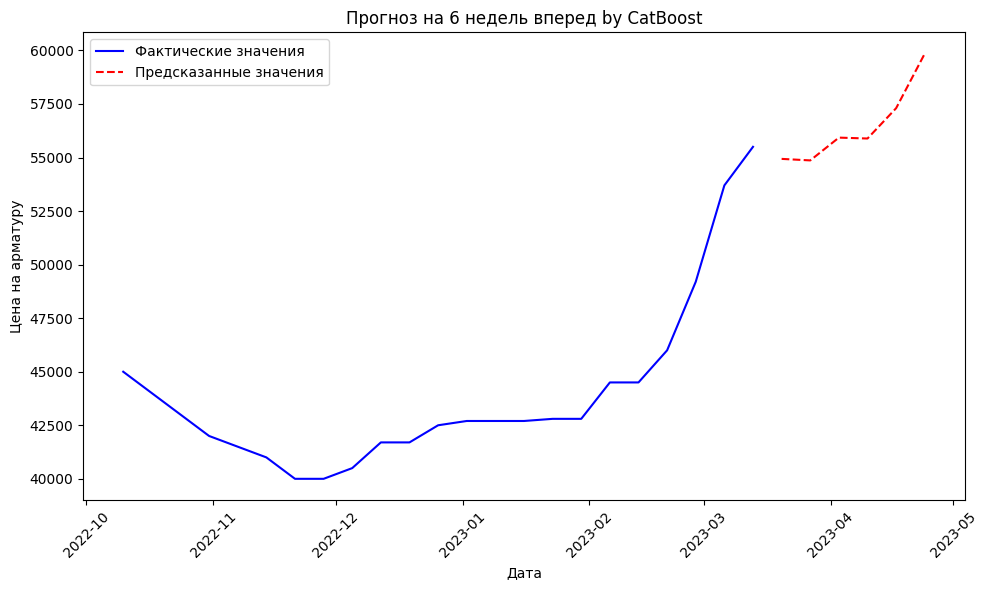

In [532]:
def visual(future_predict, model_name, n):
    plt.figure(figsize=(10, 6))
    plt.plot(test_prepared['dt'], test_prepared['Цена на арматуру'], label='Фактические значения', color='blue')

    future_dates = pd.date_range(start=test_prepared['dt'].iloc[-1] + pd.Timedelta(weeks=1), periods=n, freq='W-MON')

    # Убедимся, что future_predict имеет нужный размер
    if len(future_predict) > n:
        future_predict = future_predict[:n]  # Обрезаем до нужного размера

    plt.plot(future_dates, future_predict, label='Предсказанные значения', color='red', linestyle='--')

    plt.title(f'Прогноз на {n} недель вперед by {model_name}')
    plt.xlabel('Дата')
    plt.ylabel('Цена на арматуру')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Вызов функции с n
visual(future_predictions_CatBoost, 'CatBoost', n)

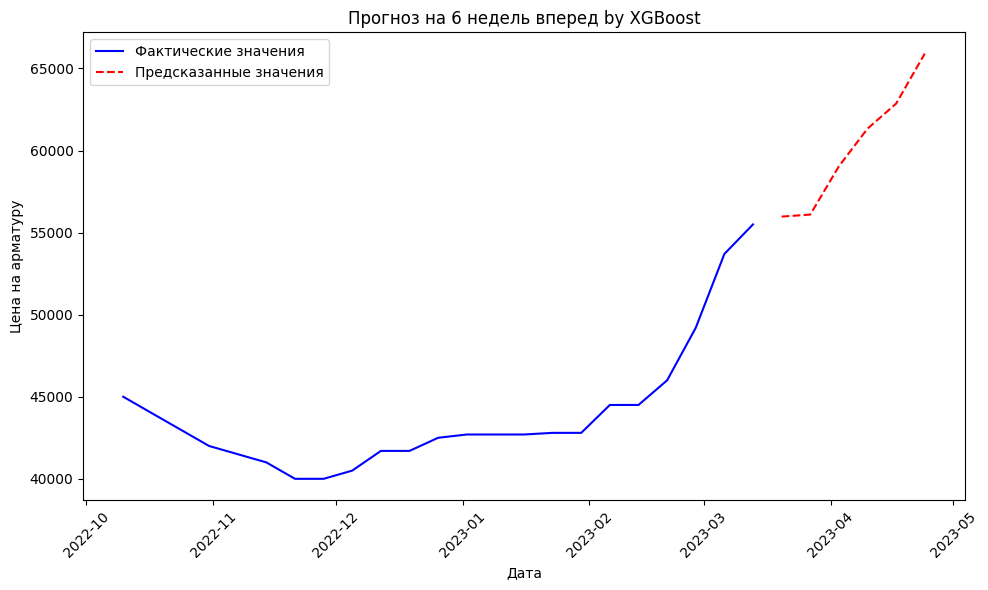

In [533]:
visual(future_predictions_XGBoost, 'XGBoost', n)

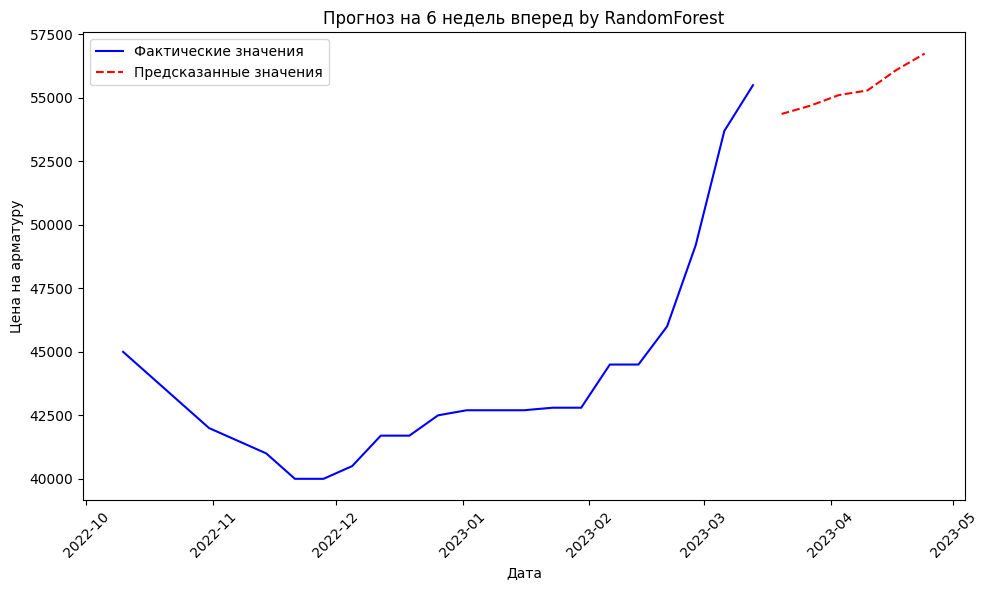

In [534]:
visual(future_predictions_RandomForest, 'RandomForest', n)

### Расчет объёма

In [535]:
# Подготовка данных для теста
X_test = test_prepared.drop(columns=["dt", "Цена на арматуру"])
y_test = test_prepared["Цена на арматуру"]

# Получение предсказаний для всех моделей
y_pred_catboost = model_catboost.predict(X_test)
y_pred_xgboost = model_xgboost.predict(X_test)
y_pred_rf = model_randomforest.predict(X_test)

# Округление предсказанных значений и сохранение в массив
y_pred_catboost = np.round(y_pred_catboost).astype(int)
y_pred_xgboost = np.round(y_pred_xgboost).astype(int)
y_pred_rf = np.round(y_pred_rf).astype(int)

# Инициализация DataFrame для сохранения результатов
test_done = test.copy()

# Массив предсказанных значений
model_names = ['CatBoost', 'XGBoost', 'RandomForest']

# Функция для рекомендации объема тендера
def main_recommend_tender_volume_(predictions, model_name):
    def perenos_():
        print('\n******************************************************************\n')

    def recommend_tender_volume(predicted_price, current_price, threshold_down=0.95, threshold_up=1.05, min_tender_weeks=1, max_tender_weeks=6, price_difference_factor=1000):
        if predicted_price < current_price * threshold_down:
            return max(min_tender_weeks, int((current_price - predicted_price) / price_difference_factor))
        elif predicted_price > current_price * threshold_up:
            return max(max_tender_weeks, int((predicted_price - current_price) / price_difference_factor))
        else:
            return (min_tender_weeks + max_tender_weeks) // 2  # Рекомендуем среднее количество недель

    current_price = test_prepared['Цена на арматуру'].iloc[-1]  # цена на арматуру сегодня

    recommended_volumes = []

    # Вычисление тендера на основе предсказанных значений
    for predicted_price in predictions:
        recommended_volume = recommend_tender_volume(predicted_price, current_price)
        recommended_volumes.append(recommended_volume)

    # Сохранение рекомендованных объемов в test_done
    # test_done['Объём'] = recommended_volumes

    # Проверка предсказанных значений
    perenos_()
    print(f"Рекомендуемый объем тендера на арматуру by {model_name}: {recommended_volumes}\n")
    print(f"Предсказанные цены by {model_name}: {predictions}")

# Вызов функции для каждой модели
main_recommend_tender_volume_(future_predictions_CatBoost, 'CatBoost')
main_recommend_tender_volume_(future_predictions_XGBoost, 'XGBoost')
main_recommend_tender_volume_(future_predictions_RandomForest, 'RandomForest')

# Сохранение обновленного DataFrame с рекомендациями
# test_done.to_excel('data/test_done.xlsx', index=False)  # Сохраняем в Excel


******************************************************************

Рекомендуемый объем тендера на арматуру by CatBoost: [3, 3, 3, 3, 3, 6]

Предсказанные цены by CatBoost: [54937, 54866, 55930, 55888, 57304, 59853]

******************************************************************

Рекомендуемый объем тендера на арматуру by XGBoost: [3, 3, 6, 6, 7, 10]

Предсказанные цены by XGBoost: [55976, 56099, 59040, 61333, 62859, 65907]

******************************************************************

Рекомендуемый объем тендера на арматуру by RandomForest: [3, 3, 3, 3, 3, 3]

Предсказанные цены by RandomForest: [54368, 54692, 55112, 55294, 56094, 56745]


### Вывод

- CatBoost и XGBoost показали хорошие значения, в отличии от RandomForest